### **Project Showcase - Depression Detection using Twitter Data**

This script contains pre-processing for the twitter data and model creation using PyTorch. 

We used TorchText, a PyTorch libray that made pre-pre-processing both simple and efficient, and applied custom techniques to work with our unique twitter data.

A lot of the preprocessing and model section was inspired by code from this article, as we are new to NLP using PyTorch - https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import seaborn as sns
import spacy
from tqdm import tqdm, tqdm_notebook, tnrange
tqdm.pandas(desc='Progress')

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
!pip install torchtext==0.4

     |████████████████████████████████| 61kB 3.1MB/s 
  Found existing installation: torchtext 0.9.1
    Uninstalling torchtext-0.9.1:
      Successfully uninstalled torchtext-0.9.1


In [5]:
import torchtext
from torchtext.data import Field, BucketIterator, TabularDataset

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [7]:
import os, sys
import re
import string
import itertools

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
print('Python version:',sys.version)
print('Pandas version:',pd.__version__)
print('Pytorch version:', torch.__version__)
print('Torch Text version:', torchtext.__version__)
print('Spacy version:', spacy.__version__)

Python version: 3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]
Pandas version: 1.1.5
Pytorch version: 1.8.1+cu101
Torch Text version: 0.4.0
Spacy version: 2.2.4


## **1. Load Data**

In [11]:
df = pd.read_csv("/content/drive/MyDrive/Dataset1/depression_data/tweets_combined.csv")

In [12]:
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [13]:
df.head()

,Unnamed: 0,tweet,target
0,2444,PUPPY FOR ADOPTIONS !!! Happy pics!! Please SHARE for exposure! Put out the word to good adopter prospects!...,0
1,1073,Do you ever just get so excited that you're trying to sleep &amp; just can't even close you eyes😁like I really need this catnap but #excitement,0
2,1355,@DOBrienAJC What did you do to rile up all the Roberts?,0
3,1738,I didn't give @chelsopat @s0ccer15 credit for bringing me chocolate milk so here it is 🙏🏼 #grateful,0
4,1942,"4th step to overcoming and is to accept you need help, if you could have done it yourself, you would have, true?",0


In [14]:
df.target.value_counts()

1    843
0    843
Name: target, dtype: int64

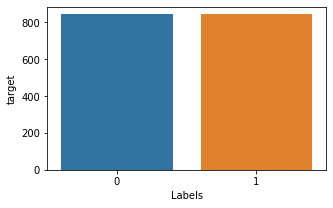

In [15]:
fig = plt.figure(figsize=(5,3))
ax = sns.barplot(x=df.target.unique(),y=df.target.value_counts());
ax.set(xlabel='Labels');

In [16]:
df.tweet.head(10), df.tweet.tail(10)

(0    PUPPY FOR ADOPTIONS !!! Happy pics!! Please SHARE for exposure! Put out the word to good adopter prospects!...                                 
 1    Do you ever just get so excited that you're trying to sleep &amp; just can't even close you eyes😁like I really need this catnap but #excitement
 2    @DOBrienAJC What did you do to rile up all the Roberts?                                                                                        
 3    I didn't give @chelsopat @s0ccer15 credit for bringing me chocolate milk so here it is 🙏🏼 #grateful                                            
 4    4th step to overcoming  and  is to accept you need help, if you could have done it yourself, you would have, true?                             
 5    You do NOT have to be a victim of  or . Change is easier than you may think; you just have to go about it the right way.                       
 6    @Dansgaming YES!! I love making my own coffee drinks at home! #super  !!                      

In [17]:
# check non-depressive tweets
df[df["target"]==0].tweet.head()

0    PUPPY FOR ADOPTIONS !!! Happy pics!! Please SHARE for exposure! Put out the word to good adopter prospects!...                                 
1    Do you ever just get so excited that you're trying to sleep &amp; just can't even close you eyes😁like I really need this catnap but #excitement
2    @DOBrienAJC What did you do to rile up all the Roberts?                                                                                        
3    I didn't give @chelsopat @s0ccer15 credit for bringing me chocolate milk so here it is 🙏🏼 #grateful                                            
4    4th step to overcoming  and  is to accept you need help, if you could have done it yourself, you would have, true?                             
Name: tweet, dtype: object

In [18]:
# check depressive tweets
df[df["target"]==1].tweet.head()

843    Lately - nothing has been going right .                                      
844    My brain caught a bug, Or maybe it was my heart, Darkness gives a fucj       
845    I am so  that I am  today                                                    
846    No I'm not  for my life.                                                     
847    Me: My "check engine" light is on. Mechanic: Which car? Me: No I said mine.  
Name: tweet, dtype: object

## **2. Define How to Preprocess Data**

In [19]:
# torchtext have trouble handling \n. Replace \n character with space
df['tweet'] = df.tweet.progress_apply(lambda x: re.sub('\n', ' ', x))

Progress: 100%|██████████| 1686/1686 [00:00<00:00, 157939.80it/s]


In [20]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

In [21]:
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

contractions, contractions_re = _get_contractions(contraction_dict)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

In [22]:
def tweet_clean(text):
    text = re.sub(r'https?:/\/\S+', ' ', text) # remove urls
    text = re.sub(r'<([^>]*)>', ' ', text) # remove emojis
    text = re.sub(r'@\w+', ' ', text) # remove at mentions
    text = re.sub(r'#', '', text) # remove hashtag symbol
    text = re.sub(r'[0-9]+', ' ', text) # remove numbers
    text = replace_contractions(text)
    pattern = re.compile(r"[ \n\t]+")
    text = pattern.sub(" ", text)      
    text = "".join("".join(s)[:2] for _, s in itertools.groupby(text))    
    text = re.sub(r'[^A-Za-z0-9,?.!]+', ' ', text) # remove all symbols and punctuation except for . , ! and ?
    return text.strip()

In [23]:
nlp = spacy.load('en',disable=['parser', 'tagger', 'ner'])
def tokenizer(s): return [w.text.lower() for w in nlp(tweet_clean(s))]

**Define fields**

In [24]:
TEXT = Field(sequential=True, tokenize=tokenizer, include_lengths=True, use_vocab=True)
TARGET = Field(sequential=False, use_vocab=False, pad_token=None, unk_token=None, is_target =False)

In [25]:
data_fields = [
    (None, None),
    ("tweet", TEXT), 
    ("target", TARGET)
]

## **3. Create Train, Valid and Test datasets**

In [26]:
def split_train_test(df, test_size=0.2):
    train, val = train_test_split(df, test_size=test_size,random_state=42)
    return train.reset_index(drop=True), val.reset_index(drop=True)

In [27]:
# create train and validation set 
train_val, test = split_train_test(df, test_size=0.2)
train, val = split_train_test(train_val, test_size=0.2)

In [28]:
train.to_csv("train.csv", index=False)
val.to_csv("val.csv", index=False)
test.to_csv("test.csv", index=False)

In [29]:
train.shape, val.shape, test.shape

((1078, 3), (270, 3), (338, 3))

[Text(0, 0.5, 'counts'), Text(0.5, 0, 'Labels'), Text(0.5, 1.0, 'test')]

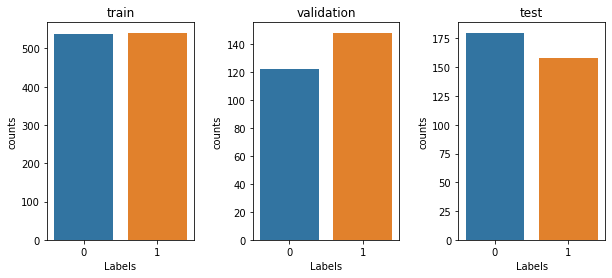

In [30]:
fig = plt.figure(figsize=(10,4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1,3,1)
ax = sns.barplot(x=train.target.unique(),y=train.target.value_counts())
ax.set(xlabel='Labels', ylabel="counts", title="train")

ax1 = fig.add_subplot(1,3,2)
ax1 = sns.barplot(x=val.target.unique(),y=val.target.value_counts())
ax1.set(xlabel='Labels', ylabel="counts", title="validation")

ax2 = fig.add_subplot(1,3,3)
ax2 = sns.barplot(x=test.target.unique(),y=test.target.value_counts())
ax2.set(xlabel='Labels', ylabel="counts", title="test")

In [31]:
%%time
train_data, val_data, test_data = TabularDataset.splits(path='./', format='csv', train='train.csv', validation='val.csv', test='test.csv', fields=data_fields, skip_header=True)

CPU times: user 1min 47s, sys: 1.72 s, total: 1min 49s
Wall time: 1min 49s


In [32]:
len(train_data), len(val_data), len(test_data)

(1078, 270, 338)

## **4. Load pretrained embeddings and build vocab**

In [33]:
!ls '/content/gdrive/My Drive/embedding'

ls: cannot access '/content/gdrive/My Drive/embedding': No such file or directory


In [34]:
%%time
vec = torchtext.vocab.Vectors( '/content/drive/MyDrive/Dataset1/depression_data/glove.twitter.27B.100d (1).txt')

100%|█████████▉| 1192814/1193514 [00:58<00:00, 20128.73it/s]

CPU times: user 1min 1s, sys: 4.59 s, total: 1min 5s
Wall time: 1min 21s


In [35]:
len(train_data)

1078

In [36]:
%%time
MAX_VOCAB_SIZE = 100_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE,
                 vectors=vec)

TARGET.build_vocab(train_data)

CPU times: user 96.2 ms, sys: 5.98 ms, total: 102 ms
Wall time: 106 ms


In [37]:
TEXT.vocab.vectors.shape

torch.Size([3408, 100])

In [38]:
train_data

## **5. Load data in batches**

We will use the BucketIterator to access the Dataloader. It sorts data according to length of text, and groups similar length text in a batch, thus reducing the amount of padding required. It pads the batch according to the max length in that particular batch

In [39]:

train_loader, val_loader, test_loader = BucketIterator.splits(datasets=(train_data, val_data, test_data), 
                                            batch_sizes=(3,3,3), 
                                            sort_key=lambda x: len(x.tweet), 
                                            device=None, 
                                            sort_within_batch=True, 
                                            repeat=False)

In [40]:
len(train_loader), len(val_loader), len(test_loader)

(360, 90, 113)

In [41]:
batch = next(iter(train_loader))
type(batch)

torchtext.data.batch.Batch

In [42]:
batch.target

tensor([0, 0, 0])

In [43]:
batch.tweet

(tensor([[  10,    6,  163],
         [  38,  191,   24],
         [ 121,   53,   11],
         [ 681,  221,  336],
         [   9,    6,  330],
         [ 763,  119,   58],
         [  21,   53,   38],
         [  73,  782,   68],
         [  34,    6,  116],
         [  46,  147,   11],
         [  10,  267,    9],
         [ 617,  143,  751],
         [ 145,   42, 2910],
         [ 290,  267, 2386],
         [  14,  248, 1376]]), tensor([15, 15, 15]))

In [51]:
TEXT.vocab.itos[1]

'<pad>'

In [52]:
def idxtosent(batch, idx):
    return ' '.join([TEXT.vocab.itos[i] for i in batch.tweet[0][:,idx].cpu().data.numpy()])

In [53]:
idxtosent(batch,0)

'you all ever heard a song so good but now you ca nt remember it'

In [54]:
batch.__dict__

{'batch_size': 3,
 'dataset': <torchtext.data.dataset.TabularDataset at 0x7f9fc9290110>,
 'fields': dict_keys([None, 'tweet', 'target']),
 'input_fields': ['tweet', 'target'],
 'target': tensor([0, 0, 0]),
 'target_fields': [],
 'tweet': (tensor([[  10,    6,  163],
          [  38,  191,   24],
          [ 121,   53,   11],
          [ 681,  221,  336],
          [   9,    6,  330],
          [ 763,  119,   58],
          [  21,   53,   38],
          [  73,  782,   68],
          [  34,    6,  116],
          [  46,  147,   11],
          [  10,  267,    9],
          [ 617,  143,  751],
          [ 145,   42, 2910],
          [ 290,  267, 2386],
          [  14,  248, 1376]]), tensor([15, 15, 15]))}

In [55]:
class BatchGenerator:
    def __init__(self, dl, x_field, y_field):
        self.dl, self.x_field, self.y_field = dl, x_field, y_field
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            X = getattr(batch, self.x_field)
            y = getattr(batch, self.y_field)
            yield (X,y)

In [56]:
train_batch_it = BatchGenerator(train_loader, 'tweet', 'target')
next(iter(train_batch_it))

((tensor([[  14,   74,   45],
          [ 647,   11, 1103],
          [  62,    9,    5],
          [ 136,  215,  232],
          [  24,  168,   99],
          [   2,    2,   64],
          [ 248,   19,  312],
          [  32,   13, 1700],
          [  12,   56,    7],
          [ 169,  326,  162],
          [  17,    3,   31],
          [   9,  127,   64],
          [1387,   49,   14],
          [ 479,    2,   38],
          [   6,   20,   10],
          [3012,    9,   57],
          [  15,  298, 1406],
          [   9,   15,   16],
          [3097, 1992,   16],
          [2359,    7,   34],
          [   3,  875,    2],
          [   2,    7,   27],
          [  66,  343, 1113],
          [   5,    7,   57],
          [ 222, 2018,    5],
          [   9,    7,   55],
          [1441,    2,    5],
          [   7,   31,   68],
          [ 112,   13,   12],
          [ 479,  136,  169],
          [   3,   14,  902],
          [   7,    3,   37]]), tensor([32, 32, 32])), tensor([1, 0, 0

## **6. Models and Training**

For the model, we decided to follow the example in https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8, but make small modifications such as adding some dropout, to prevent overfitting

The model is uses a pre-trained embedding layer from glove, a bidirectional GRU and also a concat pooling method where we perform average pool and max pool and then concatenate the results.

The final result was ok, with around 80% test accuracy. It was clear that the model was overfitting but we had run out of time to make further adjustments. This has been a very educational experience as it was our first time implementing NLP using PyTorch. We plan to experiment and improve the model using a varitey of methods in the future.

In [57]:
vocab_size = len(TEXT.vocab)
embedding_dim = 100
n_hidden = 64
n_out = 2

In [58]:
class ConcatPoolingGRUAdaptive(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_out, pretrained_vec, dropout, bidirectional=True):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.n_hidden = n_hidden
        self.n_out = n_out
        self.bidirectional = bidirectional
        
        self.emb = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.emb.weight.data.copy_(pretrained_vec)
        self.emb.weight.requires_grad = False
        self.gru = nn.GRU(self.embedding_dim, self.n_hidden, bidirectional=bidirectional)
        if bidirectional:
            self.fc = nn.Linear(self.n_hidden*2*2, self.n_out)
        else:
            self.fc = nn.Linear(self.n_hidden*2, self.n_out)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, seq, lengths):
        bs = seq.size(1)
        self.h = self.init_hidden(bs)
        seq = seq.transpose(0,1)
        embs = self.emb(seq)
        embs = embs.transpose(0,1)
        embs = pack_padded_sequence(embs, lengths)
        gru_out, self.h = self.gru(embs, self.h)
        gru_out, lengths = pad_packed_sequence(gru_out)        
        
        avg_pool = F.adaptive_avg_pool1d(gru_out.permute(1,2,0),1).view(bs,-1)
        max_pool = F.adaptive_max_pool1d(gru_out.permute(1,2,0),1).view(bs,-1) 
        
        cat = self.dropout(torch.cat([avg_pool,max_pool],dim=1))
        
        outp = self.fc(cat)
        return F.log_softmax(outp)
    
    def init_hidden(self, batch_size): 
        if self.bidirectional:
            return torch.zeros((2,batch_size,self.n_hidden)).to(device)
        else:
            return torch.zeros((1,batch_size,self.n_hidden)).cuda().to(device)

In [59]:
def train(model, iterator, optimizer, criterion, num_batch):
        y_true_train = list()
        y_pred_train = list()
        total_loss_train = 0  
  
        #t = tqdm_notebook(iterator, leave=False, total=num_batch)
    
        for (X,lengths),y in iterator:

          #t.set_description(f'Epoch {epoch}')
          lengths = lengths.cpu().numpy()

          opt.zero_grad()
          pred = model(X, lengths)
          loss = criterion(pred, y)
          loss.backward()
          opt.step()

          #t.set_postfix(loss=loss.item())
          pred_idx = torch.max(pred, dim=1)[1]

          y_true_train += list(y.cpu().data.numpy())
          y_pred_train += list(pred_idx.cpu().data.numpy())
          total_loss_train += loss.item()
            
        train_acc = accuracy_score(y_true_train, y_pred_train)
        train_loss = total_loss_train/num_batch
        return train_loss, train_acc

In [60]:
def evaluate(model, iterator, criterion, num_batch):
            y_true_val = list()
            y_pred_val = list()
            total_loss_val = 0
            for (X,lengths),y in iterator: #tqdm_notebook(iterator, leave=False): 
            
              pred = model(X, lengths.cpu().numpy())
              loss = criterion(pred, y)
              pred_idx = torch.max(pred, 1)[1]
              y_true_val += list(y.cpu().data.numpy())
              y_pred_val += list(pred_idx.cpu().data.numpy())
              total_loss_val += loss.item()
            valacc = accuracy_score(y_true_val, y_pred_val)
            valloss = total_loss_val/num_batch
            return valloss, valacc
         

In [61]:
train_loader, val_loader, test_loader = BucketIterator.splits(datasets=(train_data, val_data, test_data), 
                                            batch_sizes=(32,32,32), 
                                            sort_key=lambda x: len(x.tweet), 
                                            device=device, 
                                            sort_within_batch=True, 
                                            repeat=False)

In [62]:
train_batch_it = BatchGenerator(train_loader, 'tweet', 'target')
val_batch_it = BatchGenerator(val_loader, 'tweet', 'target')
test_batch_it = BatchGenerator(test_loader, 'tweet', 'target')

In [63]:
m = ConcatPoolingGRUAdaptive(vocab_size, embedding_dim, n_hidden, n_out, train_data.fields['tweet'].vocab.vectors, 0.5).to(device)
opt = optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), 1e-3)


In [64]:
loss_fn=F.nll_loss
epochs=10

In [65]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [66]:
best_valid_loss = float('inf')

epochs=500

for epoch in range(epochs):      

    start_time = time.time()
    
    train_loss, train_acc = train(m, iter(train_batch_it), opt, loss_fn, len(train_batch_it))
    valid_loss, valid_acc = evaluate(m, iter(val_batch_it), loss_fn, len(val_batch_it))

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(m.state_dict(), 'tut4-model.pt')
          
        
    print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {valid_loss:.4f} val_acc: {valid_acc:.4f}')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0: train_loss: 0.6782 train_acc: 0.5668 | val_loss: 0.6445 val_acc: 0.6519
Epoch 1: train_loss: 0.6025 train_acc: 0.7013 | val_loss: 0.5887 val_acc: 0.7148
Epoch 2: train_loss: 0.5425 train_acc: 0.7347 | val_loss: 0.5155 val_acc: 0.7296
Epoch 3: train_loss: 0.4998 train_acc: 0.7662 | val_loss: 0.5580 val_acc: 0.7000
Epoch 4: train_loss: 0.4877 train_acc: 0.7690 | val_loss: 0.5131 val_acc: 0.7481
Epoch 5: train_loss: 0.4580 train_acc: 0.7848 | val_loss: 0.4830 val_acc: 0.7556
Epoch 6: train_loss: 0.4442 train_acc: 0.7987 | val_loss: 0.4971 val_acc: 0.7333
Epoch 7: train_loss: 0.4105 train_acc: 0.8098 | val_loss: 0.5007 val_acc: 0.7444
Epoch 8: train_loss: 0.3970 train_acc: 0.8312 | val_loss: 0.4917 val_acc: 0.7741
Epoch 9: train_loss: 0.3524 train_acc: 0.8469 | val_loss: 0.5020 val_acc: 0.7481
Epoch 10: train_loss: 0.3389 train_acc: 0.8562 | val_loss: 0.5245 val_acc: 0.7222
Epoch 11: train_loss: 0.3267 train_acc: 0.8618 | val_loss: 0.5381 val_acc: 0.7481
Epoch 12: train_loss: 0.32

In [67]:
test_loss, test_acc = evaluate(m, iter(test_batch_it), loss_fn, len(test_batch_it))

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.682 | Test Acc: 74.26%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
import pickle

In [ ]:
filename = 'Depression2.pkl'
pickle.dump(motut4-model.ptdel, open(filename, 'wb'))

In [72]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=1500)
pickle.dump(cv, open('cv-transform.pkl', 'wb'))